In [1]:
import rootutils

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)

%load_ext autoreload
%autoreload 2

import hydra
import torch
import torch_geometric
from hydra import compose, initialize
from omegaconf import OmegaConf

from topobenchmarkx.data.preprocessor import PreProcessor
from topobenchmarkx.dataloader.dataloader import TBXDataloader
from topobenchmarkx.data.loaders import GraphLoader

from topobenchmarkx.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)


initialize(config_path="../configs", job_name="job")

/tmp/ipykernel_272091/2455096930.py:26: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="job")


hydra.initialize()

In [2]:
cfg = compose(config_name="run.yaml", 
              overrides=["dataset=graph/cocitation_cora", "model=hypergraph/allsettransformer"], 
              return_hydra_config=True)
graph_loader = GraphLoader(cfg.dataset.loader.parameters)
dataset, dataset_dir = graph_loader.load()
preprocessed_dataset = PreProcessor(dataset, dataset_dir, cfg['transforms'])

Transform parameters are the same, using existing data_dir: /TopoBenchmarkX/datasets/graph/cocitation/Cora/graph2hypergraph_lifting/1273654097


In [3]:
print(cfg['transforms'])

{'graph2hypergraph_lifting': {'_target_': 'topobenchmarkx.transforms.data_transform.DataTransform', 'transform_type': 'lifting', 'transform_name': 'HypergraphKHopLifting', 'k_value': 1}}


In [4]:
data = preprocessed_dataset[0]

In [5]:
data.keys()

['val_mask',
 'edge_index',
 'x',
 'x_hyperedges',
 'y',
 'num_hyperedges',
 'x_0',
 'train_mask',
 'incidence_hyperedges',
 'test_mask']

In [6]:
# shape is a list, it breaks everything if we keep it
if hasattr(data, "shape"):
    del data["shape"]
    
    
# replace adjacency keys with temp
n_incidences = len([key for key in data.keys() if "incidence" in key])
for i in range(n_incidences):
    if f"adjacency_{i}" in data.keys():
        data[f"temp_{i}"] = data[f"adjacency_{i}"]
        del data[f"adjacency_{i}"]

# For some reason we need to call the adjacency matrices something else because the __cat_dim__ function will return a tuple for attributes with the adjacency or adj keys. This behaviour breaks stuff in the GlobalStorage module.
# for key in data.keys():
#     value = data[key]
#     print(key)
#     print(value.shape)
#     print(data._parent().__cat_dim__(key, value, data))

In [9]:
# Training, validation and split idxs should be defined somewhere, here we use a toy example
rank = 1
if hasattr(data, "x_hyperedges") and rank==1:
    n_cells = data.x_hyperedges.shape[0]
else:
    n_cells = data[f'x_{rank}'].shape[0]

train_prop = 0.5
n_train = int(train_prop * n_cells)
train_mask = torch.zeros(n_cells, dtype=torch.bool)
train_mask[:n_train] = 1

if rank != 0:
    y = torch.zeros(n_cells, dtype=torch.long)
    data.y = y
batch_size = 2

In [21]:
from torch_geometric.loader import NeighborLoader
from torch_sparse import SparseTensor
import torch_sparse

def change_sparse(tensor):
    r""" Change from SparseTensor to torch_sparse_coo_tensor or viceversa.
    
    Parameters
    ----------
    tensor: torch.Tensor or SparseTensor
        The input tensor.
    
    Returns
    -------
    torch.Tensor or SparseTensor
        The output tensor.
    
    """
    if isinstance(tensor, SparseTensor):
        return tensor.to_torch_sparse_coo_tensor().to(device=tensor.device())
    elif tensor.is_sparse:
        tensor = tensor.coalesce()
        return SparseTensor(row=tensor.indices()[0], 
                            col=tensor.indices()[1], 
                            value=tensor.values(), 
                            sparse_sizes=tensor.size()).to_device(tensor.device)
    else:
        raise NotImplementedError(f"Type {type(tensor)} not supported")
    
def clique_expansion(data, rank=0, is_hypergraph=False):
    ''' This function adds edges between cells that belong to the same higher-order cells.
    
    This function is needed so that the NeighborLoader can select all the nodes of the cells that contain the nodes of interest. In general nodes belonging to the same higher-order cell do not need to be directly connected. E.g. in a cell complex a face of 4 nodes does not have edges between opposite nodes.
    
    Parameters
    ----------
    data: torch_geometric.data.Data
        The input data.
    rank: int
        The rank of the cells that you want to batch over.
    is_hypergraph: bool
        Whether the data represents an hypergraph.
        
    Returns
    -------
    torch_geometric.data.Data
        The output data with the added edges.
    '''
    if is_hypergraph:
        P = data.incidence_hyperedges
        Q = torch.sparse.mm(P,P.T)
        edges = Q.indices()
    else:
        # get number of incidences
        max_rank = len([key for key in data.keys() if "incidence" in key])-1
        if rank > max_rank:
            raise ValueError(f"Rank {rank} is greater than the maximum rank {max_rank} in the data.")
        if rank == max_rank:
            edges = torch.empty((2, 0), dtype=torch.long)
        else:
            P = data[f"incidence_{rank+1}"]
            Q = torch.sparse.mm(P,P.T)
            edges = Q.indices()
            
        for i in range(rank+1, max_rank):
            P = torch.sparse.mm(P, data[f"incidence_{i+1}"])
            Q = torch.sparse.mm(P,P.T)
            edges = torch.cat((edges, Q.indices()), dim=1)
            
        if rank == 0:
            edges = torch.cat((edges, data.edge_index), dim=1)
        else:
            P = data[f"incidence_{rank}"]
            for i in range(rank-1, 0, -1):
                P = torch.sparse.mm(data[f"incidence_{i}"], P)
                Q = torch.sparse.mm(P.T,P)
                edges = torch.cat((edges, Q.indices()), dim=1)
            
    edges = torch.unique(edges, dim=1)
    # Remove self edges
    mask = edges[0, :] != edges[1, :]
    edges = edges[:, mask]
    
    data.edge_index = edges
    
    # We need to set x to x_rank since NeighborLoader will take the number of nodes from the x attribute
    if is_hypergraph and rank == 1:
        data.x = data.x_hyperedges
    else:
        data.x = data[f'x_{rank}']
    
    return data

def reduce_higher_ranks_incidences(batch, cells_ids, rank, max_rank, is_hypergraph=False):
    """ Reduce the incidences with higher rank than the specified one.
    
    Parameters
    ----------
    batch: torch_geometric.data.Data
        The input data.
    cells_ids: list[torch.Tensor]
        List of tensors containing the ids of the cells. The length of the list should be equal to the maximum rank.
    rank: int
        The rank to select the higher order incidences.
    max_rank: int
        The maximum rank of the incidences.
    is_hypergraph: bool
        Whether the data represents an hypergraph.
        
    Returns
    -------
    torch_geometric.data.Data
        The output data with the reduced incidences.
    """
    for i in range(1, max_rank+1):
        if is_hypergraph:
            incidence = change_sparse(batch.incidence_hyperedges)
        else:
            incidence = change_sparse(batch[f"incidence_{i}"])
        if i != rank+1:
            incidence = incidence[cells_ids[i-1], :]
        cells_ids[i] = torch.where(torch_sparse.sum(incidence, dim=0).to_dense() > 1)[0]
        incidence = incidence[:, cells_ids[i]]
        batch[f"incidence_{i}"] = change_sparse(incidence)
    if not is_hypergraph:
        incidence = change_sparse(batch[f"incidence_0"])
        incidence = incidence[:, cells_ids[0]]
        batch[f"incidence_0"] = change_sparse(incidence)
    
    return batch, cells_ids

def get_node_indices(batch, cells_ids, rank, is_hypergraph=False):
    """ Get the indices of the nodes contained by the cells specified in cells_ids and rank.
    
    Parameters
    ----------
    batch: torch_geometric.data.Data
        The input data.
    cells_ids: list[torch.Tensor]
        List of tensors containing the ids of the cells. The length of the list should be equal to the maximum rank.
    rank: int
        The rank of the cells to consider.
    is_hypergraph: bool
        Whether the data represents an hypergraph.
    
    Returns
    -------
    torch.Tensor
        The indices of the nodes contained by the cells.
    """
    cells_ids_new = [c_i for c_i in cells_ids]
    for i in range(rank, 0, -1):
        if is_hypergraph:
            incidence = change_sparse(batch.incidence_hyperedges)
        else:
            incidence = change_sparse(batch[f"incidence_{i}"].clone())
        incidence = incidence[:, cells_ids_new[i]]
        cells_ids_new[i-1] = torch.where(torch_sparse.sum(incidence, dim=1).to_dense() > 0)[0]
    return cells_ids_new[0]

def reduce_matrices(batch, cells_ids, names, rank, max_rank):
    """ Reduce the matrices using the indices in cells_ids. 
    
    The matrices are assumed to be in the batch with the names specified in the list names.
    
    Parameters
    ----------
    batch: torch_geometric.data.Data
        The input data.
    cells_ids: list[torch.Tensor]
        List of tensors containing the ids of the cells. The length of the list should be equal to the maximum rank.
    names: list[str]
        List of names of the matrices in the batch. They should appear in the format f"{name}{i}" where i is the rank of the matrix.
    rank: int
        The rank over which you are batching.
    max_rank: int
        The maximum rank of the matrices.
    
    Returns
    -------
    torch_geometric.data.Data
        The output data with the reduced matrices.
    """
    for i in range(max_rank+1):
        for name in names:
            if f"{name}{i}" in batch.keys():
                matrix = change_sparse(batch[f"{name}{i}"])
                if i==rank:
                    matrix = matrix[:, cells_ids[i]]
                else:
                    matrix = matrix[cells_ids[i], cells_ids[i]]
                batch[f"{name}{i}"] = change_sparse(matrix)
    return batch

def reduce_neighborhoods(batch, rank=0, remove_self_loops=True):
    """ Reduce the neighborhoods of the cells in the batch.
    
    Parameters
    ----------
    batch: torch_geometric.data.Data
        The input data.
    rank: int
        The rank of the cells to batch over.
    remove_self_loops: bool
        Whether to remove self loops from the edge_index.
    
    Returns
    -------
    torch_geometric.data.Data
        The output data with the reduced neighborhoods.
    """
    is_hypergraph = False
    if hasattr(batch, 'incidence_hyperedges'):
        is_hypergraph = True
        max_rank = 1
    else:
        max_rank = len([key for key in batch.keys() if "incidence" in key])-1
    
    if rank > max_rank:
        raise ValueError(f"Rank {rank} is greater than the maximum rank {max_rank} in the dataset.")
    
    cells_ids = [None for _ in range(max_rank+1)]
    # the ids of the cells are saved in the batch
    cells_ids[rank] = batch.n_id
    
    if rank != 0:
        cells_ids[0] = get_node_indices(batch, cells_ids, rank, is_hypergraph)
    else:
        cells_ids[0] = batch.n_id
    batch, cells_ids = reduce_higher_ranks_incidences(batch, cells_ids, rank, max_rank, is_hypergraph)

    batch = reduce_matrices(batch, 
                            cells_ids, 
                            names=['down_laplacian_', 'up_laplacian_', 'hodge_laplacian_', 'temp_'],
                            rank=rank,
                            max_rank=max_rank)
                
    # reduce the feature matrices
    for i in range(max_rank+1):
        if i != rank:
            if f"x_{i}" in batch.keys():
                batch[f"x_{i}"] = batch[f"x_{i}"][cells_ids[i]]
            
    # change the temp matrices back to adjacency
    for i in range(max_rank+1):
        if f"temp_{i}" in batch.keys():
            batch[f"adjacency_{i}"] = batch[f"temp_{i}"]
            del batch[f"temp_{i}"]
            
    # fix edge_index
    if hasattr(batch, 'adjacency_0'):
        adjacency_0 = batch.adjacency_0.coalesce()
        edge_index = adjacency_0.indices()
        if remove_self_loops:
            edge_index = torch_geometric.utils.remove_self_loops(edge_index)[0]
        batch.edge_index = edge_index
    
    # fix x
    batch.x = batch[f"x_0"]
    
    return batch

class ReduceNeighborhoods():
    """ Reduce the neighborhoods of the cells in the batch.
    
    Parameters
    ----------
    rank: int
        The rank of the cells to batch over.
    remove_self_loops: bool
        Whether to remove self loops from the edge_index.
    """
    
    def __init__(self, rank=0, remove_self_loops=True):
        self.rank = rank
        self.remove_self_loops = remove_self_loops
        
    def __call__(self, batch):
        """ Call reduce_neighborhoods.
        
        Parameters
        ----------
        batch: torch_geometric.data.Data
            The input data.
        
        Returns
        -------
        torch_geometric.data.Data
            The output data with the reduced neighborhoods.
        """
        return reduce_neighborhoods(batch, self.rank, self.remove_self_loops)

class NeighborLoaderWrapper(NeighborLoader):
    """ NeighborLoader with clique expansion.
    
    Parameters
    ----------
    dataset: torch_geometric.data.Dataset
        The input dataset.
    rank: int
        The rank of the cells to batch over.
    **kwargs: dict
        Additional arguments for the NeighborLoader.
    """
    def __init__(self, dataset, rank=0, **kwargs):
        is_hypergraph = hasattr(dataset, 'incidence_hyperedges')
        dataset = clique_expansion(dataset, rank, is_hypergraph)
        if 'num_neighbors' in kwargs.keys():
            if len(kwargs['num_neighbors']) > 1:
                raise NotImplementedError("NeighborLoaderWrapper only supports one-hop neighborhood selection.")
        super(NeighborLoaderWrapper, self).__init__(dataset, **kwargs)
        

In [22]:
# num_neighbors controls also the number of hops (for 2 hops do num_neighbors=[-1, -1])
reduce = ReduceNeighborhoods(rank=rank, remove_self_loops=True)

loader = NeighborLoaderWrapper(data,
                               rank=rank,
                               num_neighbors=[-1],
                               input_nodes=train_mask,
                               batch_size=batch_size,
                               shuffle=False,
                               transform=reduce)

/usr/local/lib/python3.11/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [24]:
for batch in loader:
    print(batch)
    print(batch.n_id)
    print(batch.edge_index)
    if hasattr(batch, 'incidence_hyperedges'):
        print(batch.incidence_hyperedges.to_dense())
    else:
        print(batch.incidence_3.to_dense())
        print(batch.incidence_2.to_dense())
        print(batch.incidence_1.to_dense())
    break

Data(x=[17, 1433], edge_index=[2, 15], y=[17], train_mask=[17], val_mask=[17], test_mask=[17], incidence_hyperedges=[17, 2708], num_hyperedges=2708, x_0=[17, 1433], x_hyperedges=[17, 1433], n_id=[17], e_id=[15], input_id=[2], batch_size=2, incidence_1=[17, 29])
tensor([   0,    1,  926, 1862, 2582, 1166,  633, 1701, 1866,  332, 1986,  470,
        1666,  652,  654,    2, 1454])
tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1]])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])


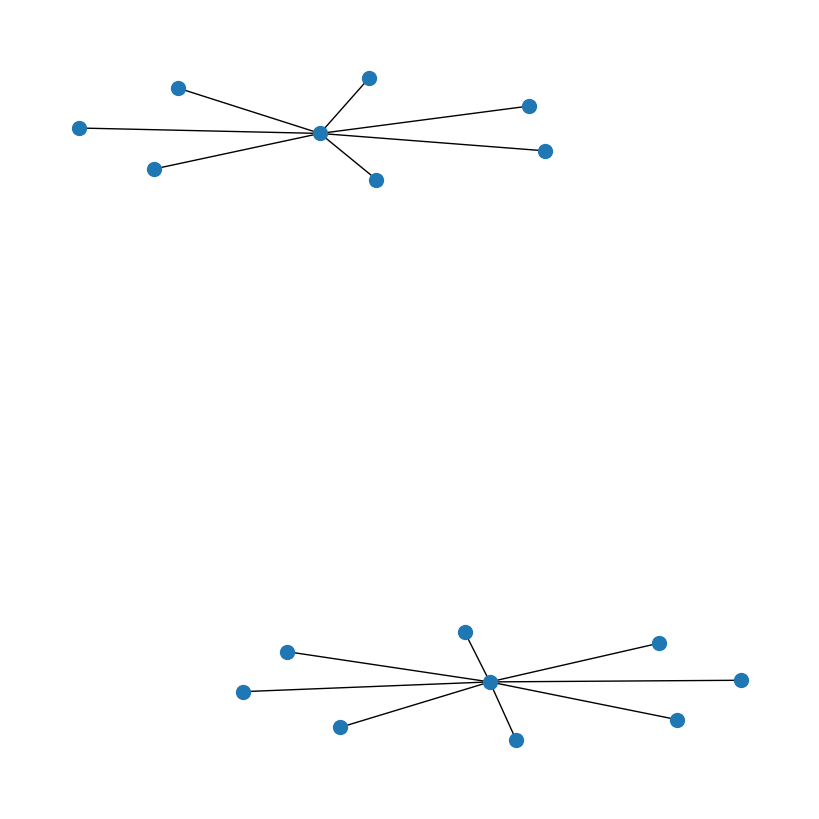

In [25]:
#use networkx to plot the batch graph
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(data):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.T.numpy())
    list_nodes = dict(G.nodes.data())

    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=100)
    
    plt.show()

for batch in loader:
    plot_graph(batch)
    break

In [26]:
if hasattr(data, 'incidence_3'):
    del data['incidence_3']
if hasattr(data, 'x_3'):
    del data['x_3']
for key in list(data.keys()):
    if 'laplacian' in key or 'temp' in key or 'mask' in key or 'hyperedges' in key:
        del data[key]

incidence_3 = torch.tensor([[],[]]).to_sparse()
incidence_2 = torch.tensor([[1,0],[1,0],[1,0],[0,0],[0,1],[0,1],[0,1]]).float().to_sparse()
incidence_1 = torch.tensor([[1,0,1,0,0,0,0],[1,1,0,0,0,0,0],[0,1,1,1,0,0,0],[0,0,0,1,1,0,1],[0,0,0,0,1,1,0],[0,0,0,0,0,1,1]]).float().to_sparse()
incidence_0 = torch.tensor([[1,1,1,1,1,1]]).float().to_sparse()
data  

Data(x=[2708, 1433], edge_index=[2, 96888], y=[2708], x_0=[2708, 1433])

Data(x=[6, 6], edge_index=[2, 14], y=[6], x_0=[6, 6], incidence_3=[2, 0], incidence_2=[7, 2], incidence_1=[6, 7], incidence_0=[1, 6], x_3=[0], x_2=[2, 2], x_1=[7, 3], temp_0=[6, 6])


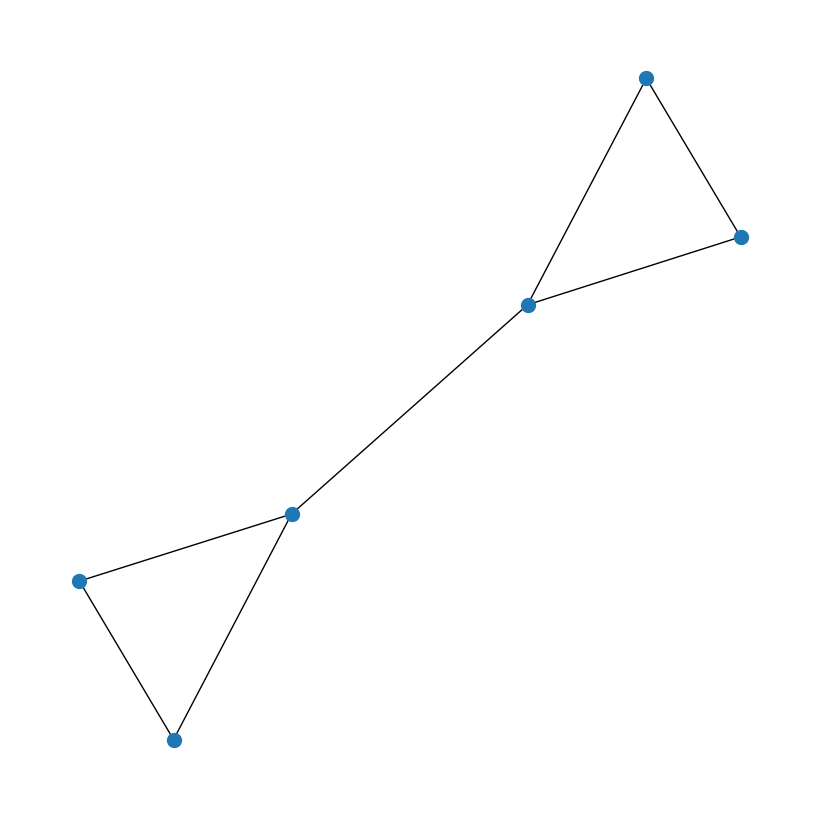

In [27]:
rank = 0

data['incidence_3'] = incidence_3
data['incidence_2'] = incidence_2
data['incidence_1'] = incidence_1
data['incidence_0'] = incidence_0

data['x_3'] = torch.tensor([]).float()
data['x_2'] = torch.tensor([[1,0],[0,1]]).float()
data['x_1'] = torch.tensor([[1,0,0],[0,1,0],[0,0,1],[1,0,0],[0,1,0],[0,0,1],[1,0,0]]).float()
data['x_0'] = torch.tensor([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]).float()
data['x'] = data[f'x_{rank}']
data['y'] = torch.zeros(data[f'x_{rank}'].shape[0], dtype=torch.long)

data['edge_index'] = torch.tensor([[0,0,1,1,2,2,2,3,3,3,4,4,5,5],[1,2,0,2,0,1,3,2,4,5,3,5,3,4]])
data['temp_0'] = torch.sparse_coo_tensor(data['edge_index'], torch.ones(data['edge_index'].shape[1]), data['x_0'].shape)
print(data)
plot_graph(data)

In [28]:
# num_neighbors controls also the number of hops (for 2 hops do num_neighbors=[-1, -1])
reduce = ReduceNeighborhoods(rank=rank, remove_self_loops=True)
batch_size = 1
loader = NeighborLoaderWrapper(data,
                               rank=rank,
                               num_neighbors=[-1],
                               input_nodes=train_mask,
                               batch_size=batch_size,
                               shuffle=False,
                               transform=reduce)

/usr/local/lib/python3.11/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


tensor([[0., 1., 1., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.]])


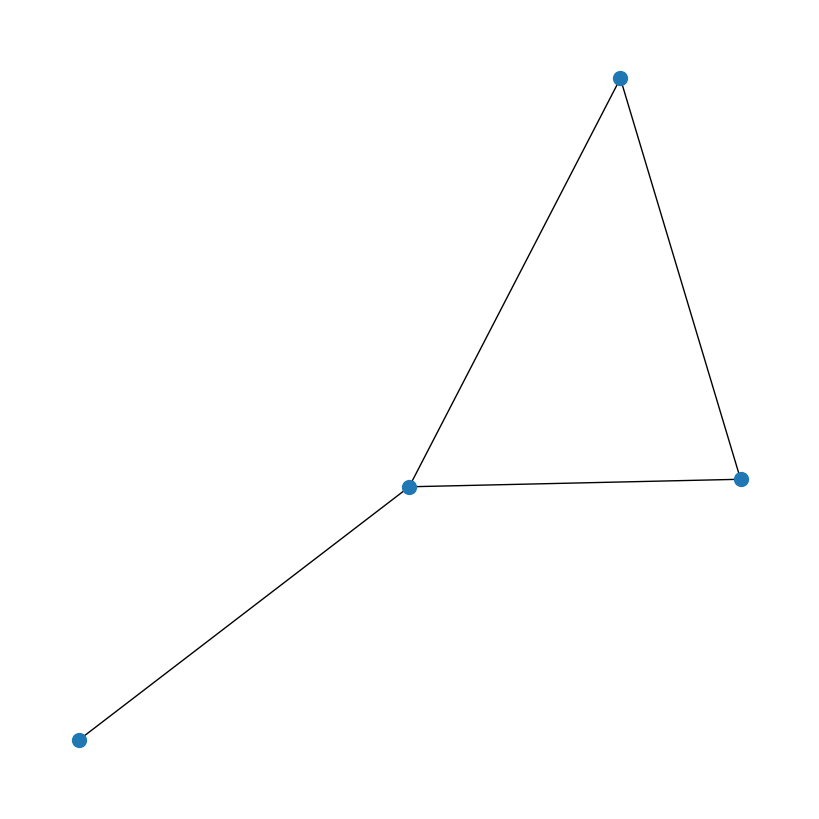

Data(x=[4, 6], edge_index=[2, 8], y=[4], x_0=[4, 6], incidence_3=[1, 0], incidence_2=[4, 1], incidence_1=[4, 4], incidence_0=[1, 4], x_3=[0], x_2=[1, 2], x_1=[4, 3], n_id=[4], e_id=[3], input_id=[1], batch_size=1, adjacency_0=[4, 4])
tensor([2, 0, 1, 3])


In [29]:
for i, batch in enumerate(loader):
    if i==2:
        print(batch.adjacency_0.to_dense())
        plot_graph(batch)
        print(batch)
        print(batch.n_id)
        break


Data(x=[4, 2], edge_index=[2, 12], y=[4], x_0=[4, 4], incidence_3=[4, 1], incidence_2=[6, 4], incidence_1=[4, 6], incidence_0=[1, 4], x_3=[1, 2], x_2=[4, 2], x_1=[6, 3], temp_0=[4, 4])


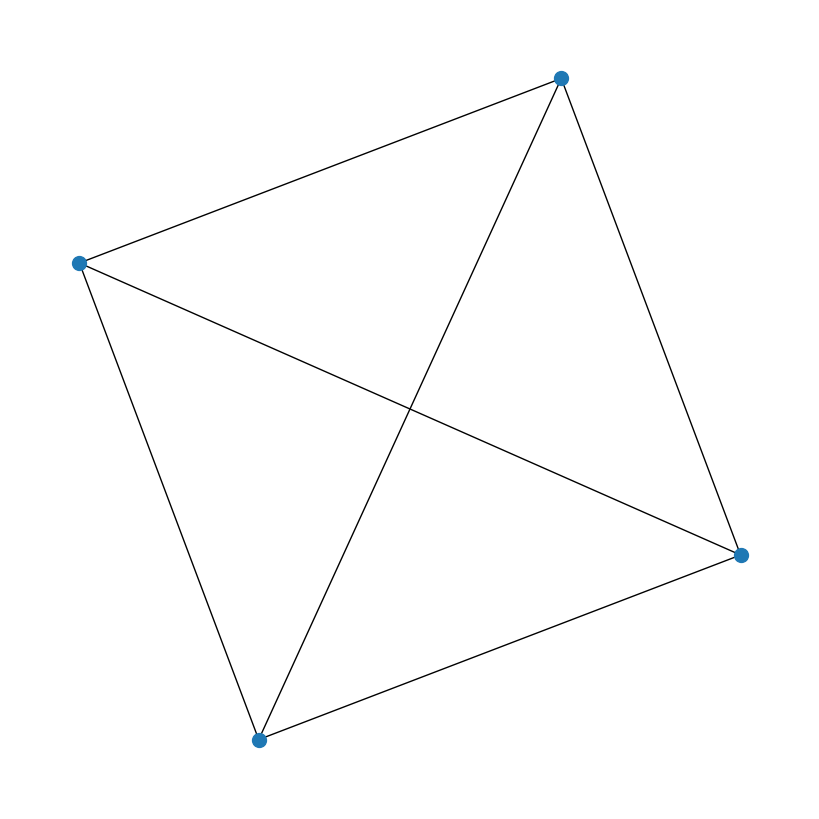

In [30]:
incidence_3 = torch.tensor([[1],[1],[1],[1]]).float().to_sparse()
incidence_2 = torch.tensor([[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,0,1,1],[1,0,0,1],[0,1,0,1]]).float().to_sparse()
incidence_1 = torch.tensor([[1,1,1,0,0,0],[1,0,0,1,1,0],[0,1,0,0,1,1],[0,0,1,1,0,1]]).float().to_sparse()
incidence_0 = torch.tensor([[1,1,1,1]]).float().to_sparse()

x_3 = torch.tensor([[1,0]]).float()
x_2 = torch.tensor([[1,0],[0,1],[1,1],[0,0]]).float()
x_1 = torch.tensor([[1,0,0],[0,1,0],[0,0,1],[1,0,0],[0,1,0],[0,0,1]]).float()
x_0 = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]).float()

rank = 2

data['incidence_3'] = incidence_3
data['incidence_2'] = incidence_2
data['incidence_1'] = incidence_1
data['incidence_0'] = incidence_0

data['x_3'] = x_3
data['x_2'] = x_2
data['x_1'] = x_1
data['x_0'] = x_0
data['x'] = data[f'x_{rank}']
data['y'] = torch.zeros(data[f'x_{rank}'].shape[0], dtype=torch.long)

data['edge_index'] = torch.tensor([[0,0,0,1,1,1,2,2,2,3,3,3],[1,2,3,0,2,3,0,1,3,0,1,2]])
data['temp_0'] = torch.sparse_coo_tensor(data['edge_index'], torch.ones(data['edge_index'].shape[1]), data['x_0'].shape)
print(data)
plot_graph(data)

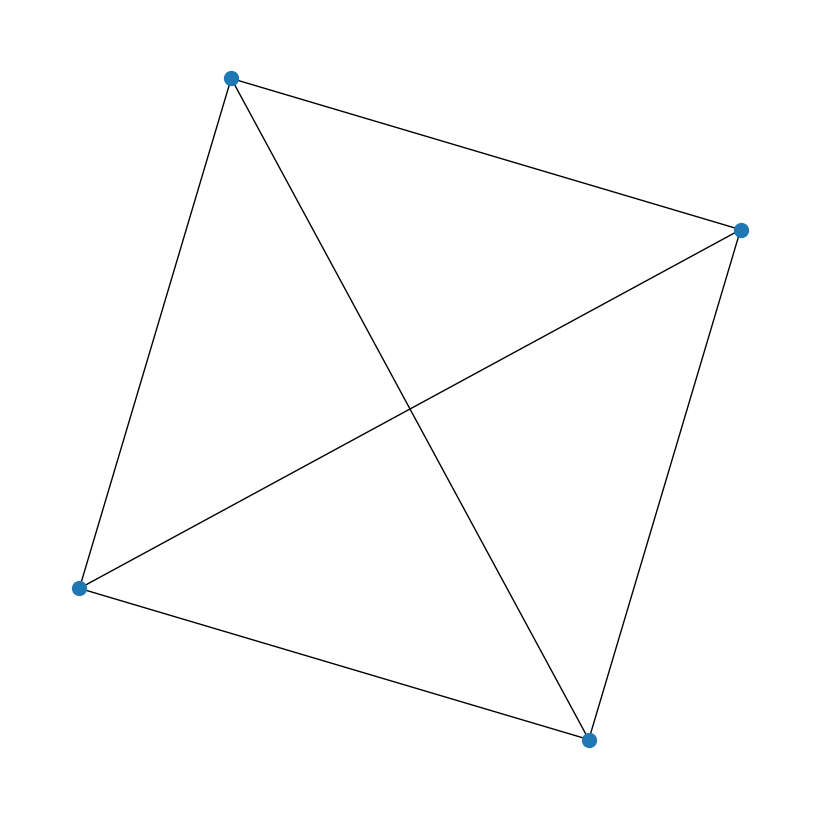

Data(x=[4, 4], edge_index=[2, 12], y=[4], x_0=[4, 4], incidence_3=[4, 1], incidence_2=[6, 4], incidence_1=[4, 6], incidence_0=[1, 4], x_3=[1, 2], x_2=[4, 2], x_1=[6, 3], n_id=[4], e_id=[3], input_id=[1], batch_size=1, adjacency_0=[4, 4])
tensor([0, 1, 2, 3])


In [31]:
# num_neighbors controls also the number of hops (for 2 hops do num_neighbors=[-1, -1])
reduce = ReduceNeighborhoods(rank=rank, remove_self_loops=True)
batch_size = 1
loader = NeighborLoaderWrapper(data,
                               rank=rank,
                               num_neighbors=[-1],
                               input_nodes=train_mask,
                               batch_size=batch_size,
                               shuffle=False,
                               transform=reduce)

for i, batch in enumerate(loader):
    if i==0:
        plot_graph(batch)
        print(batch)
        print(batch.n_id)
        break